In [202]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [203]:
errs = pd.read_csv("errs.csv")["0"]

In [204]:
errs

0     0.654665
1     0.643610
2     0.621402
3     0.557034
4     0.276958
        ...   
57    0.175472
58    0.175150
59    0.175147
60    0.174592
61    0.174411
Name: 0, Length: 62, dtype: float64

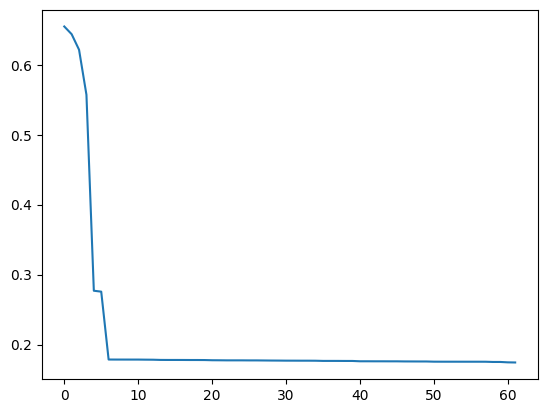

In [205]:
plt.plot(errs)

In [206]:
M = pd.read_csv("M.csv").set_index("Unnamed: 0").to_numpy()

array([1., 1., 1., 1., 1., 1., 1., 1.])

In [253]:
Madjust = M / np.sum(M,axis=1)

In [255]:
Madjust - M

array([[0.00000000e+00, 2.77555756e-17, 2.77555756e-17, 2.77555756e-17,
        2.77555756e-17, 5.55111512e-17, 1.38777878e-17, 5.55111512e-17],
       [8.32667268e-17, 0.00000000e+00, 2.77555756e-17, 1.38777878e-17,
        5.55111512e-17, 5.55111512e-17, 1.38777878e-17, 5.55111512e-17],
       [2.77555756e-17, 1.38777878e-17, 0.00000000e+00, 2.77555756e-17,
        5.55111512e-17, 2.08166817e-17, 5.55111512e-17, 2.77555756e-17],
       [4.16333634e-17, 6.93889390e-18, 1.11022302e-16, 0.00000000e+00,
        1.38777878e-17, 4.16333634e-17, 5.55111512e-17, 4.16333634e-17],
       [1.11022302e-16, 2.77555756e-17, 4.16333634e-17, 2.77555756e-17,
        0.00000000e+00, 2.77555756e-17, 1.38777878e-17, 4.16333634e-17],
       [5.55111512e-17, 2.77555756e-17, 2.77555756e-17, 1.38777878e-17,
        1.38777878e-17, 0.00000000e+00, 2.77555756e-17, 1.11022302e-16],
       [4.16333634e-17, 6.93889390e-18, 8.32667268e-17, 5.55111512e-17,
        2.77555756e-17, 5.55111512e-17, 0.00000000e+00, 5.

In [256]:
def TCP(y:np.array,M:np.array, tol=1e-4, max_iter_sub=1000):
    # eliminated = np.array([False]*len(y)).reshape(-1,1)
    # eliminated[np.isnan(y)] = True # Parties not running are eliminated
    yhats = []
    yhat = y.copy()
    yhats.append(yhat.copy())
    yhat[np.isnan(yhat)] = 0
    for _ in range(max_iter_sub):
        argssorted = np.argsort(yhat.reshape(-1))
        argssorted = argssorted[yhat.reshape(-1)[argssorted]>0] # Remove parties that are eliminated
        smallest_remaining_party = argssorted[0] # Index of smallest remaining party
        flow = np.zeros_like(yhat)
        flow[smallest_remaining_party] = 1
        flow =  M @ flow

        yhat = yhat + flow*yhat[smallest_remaining_party]
        yhat[smallest_remaining_party,0] = 0

        yhat[yhat<tol] = 0
        yhat = yhat / np.nansum(yhat)
        yhats.append(yhat.copy())

        if sum(yhat!=0)[0] == 2:
            return yhat,yhats #,yhats#, eliminated
    return yhat,yhats

In [257]:
first_pref_df = pd.read_csv("HouseFirstPrefsByCandidateByVoteTypeDownload-27966.csv",header=1)

parties_collected = ['UAPP', 'ON', 'ALP', 'IND', 'GRN', 'LP','NP','CLP','LNP','XEN', 'KAP']
party_mappers = {
    'UAPP':'UAP', 
    'ON':'ONP',
    'ALP':'ALP', 
    'IND':'IND', 
    'GRN':'GRN',
    'GVIC':'GRN',
    'LP':'LNP',
    'NP':'LNP',
    'CLP':'LNP',
    'LNP':'LNP',
    'XEN':'IND',
    'KAP':'IND',
}

# modeled_parties = ['UAP', 'ONP', 'ALP', 'GRN', 'LIB', 'NAT', 'CLP', 'LNP', 'IND', 'KAP', 'TEAL', 'OTH']
modeled_parties = ['UAP', 'ONP', 'ALP', 'GRN', 'LNP', 'IND', 'TEAL', 'OTH']

def partymap(row):
    party = row['PartyAb']
    if party in modeled_parties:
        party = party
    elif party in party_mappers.keys():
        party = party_mappers[party]
    elif pd.isna(party):
        if pd.isna(row['Surname']):
            party = "Informal"
        else:
            party = "IND"
    else:
        party = "OTH"
    row['PartyAb'] = party
    return row



first_pref_df = first_pref_df.apply(partymap,axis=1)
first_pref_df.head()

,StateAb,DivisionID,DivisionNm,CandidateID,Surname,GivenNm,BallotPosition,Elected,HistoricElected,PartyAb,PartyNm,OrdinaryVotes,AbsentVotes,ProvisionalVotes,PrePollVotes,PostalVotes,TotalVotes,Swing
0,ACT,318,Bean,36239,CONWAY,Sean,1,N,N,UAP,United Australia Party,2479,72,7,110,163,2831,0.48
1,ACT,318,Bean,37455,AMBARD,Benjamin,2,N,N,ONP,Pauline Hanson's One Nation,2304,49,5,108,214,2680,2.72
2,ACT,318,Bean,36231,SMITH,David,3,Y,Y,ALP,Australian Labor Party,35883,590,106,915,3566,41060,3.59
3,ACT,318,Bean,32130,CHRISTIE,Jamie,4,N,N,IND,Independent,6953,124,11,176,759,8023,-0.12
4,ACT,318,Bean,36243,SAVERY,Kathryn Jane,5,N,N,GRN,The Greens,12474,396,42,489,1158,14559,1.71


In [258]:
teal_candidates = pd.read_csv("teals.csv")
teal_candidates.head()

for idx,teal in teal_candidates.iterrows():
    givenNm = teal['GivenNm']
    surname = teal['Surname']
    division = teal['DivisionNm']
    first_pref_df.loc[(first_pref_df[['GivenNm','Surname','DivisionNm']]==[givenNm,surname,division]).all(axis=1),'PartyAb']="TEAL"

In [277]:
divisionName = "Brisbane"

d= first_pref_df[first_pref_df["DivisionNm"] == divisionName]
primary = pd.pivot_table(d, columns='PartyAb', values='TotalVotes', aggfunc='sum')
for party in modeled_parties:
    if party not in primary.columns:
        primary[party] = np.nan
primarynumpy = primary.reindex(modeled_parties,axis=1).to_numpy().reshape(-1,1)
primarynumpy = primarynumpy / np.nansum(primarynumpy)
(primary.reindex(modeled_parties,axis=1)/ np.nansum(primary)*100).round(1)

PartyAb,UAP,ONP,ALP,GRN,LNP,IND,TEAL,OTH
TotalVotes,1.9,2.2,26.7,26.7,36.9,2.1,NaN,3.5


In [278]:
ydist, ys = TCP(primarynumpy,M)
pd.Series(ydist.reshape(-1),index=modeled_parties)

UAP     0.000000
ONP     0.000000
ALP     0.000000
GRN     0.471014
LNP     0.528986
IND     0.000000
TEAL    0.000000
OTH     0.000000
dtype: float64

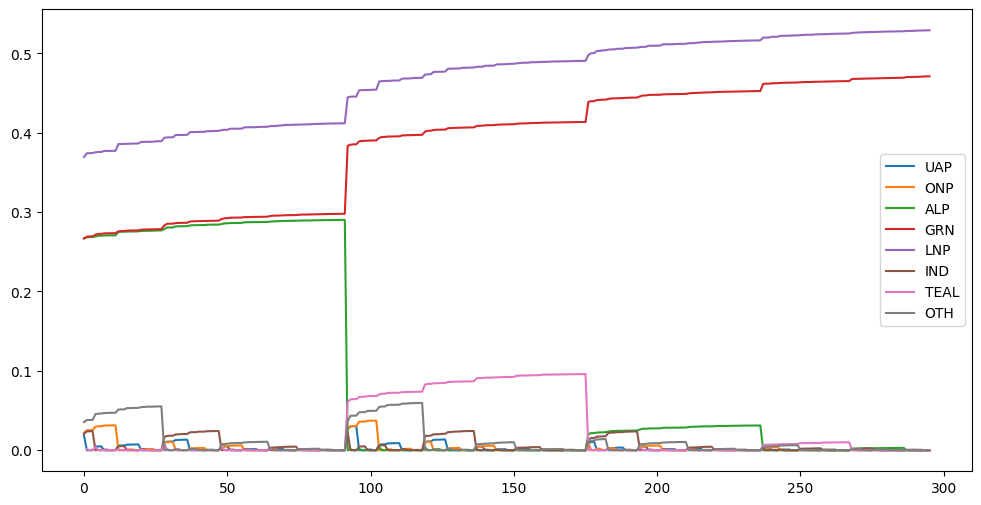

In [279]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
pd.DataFrame(np.concatenate(ys, axis=1).T, columns=modeled_parties).plot(ax=ax)
plt.show()